In [1]:
%pylab inline
%config InlineBackend.figure_formats=['png2x']

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyart
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc)
import filterpy

from siphon.radarserver import RadarServer
from matplotlib.font_manager import FontProperties
from datetime import datetime, timedelta
import wget


Populating the interactive namespace from numpy and matplotlib


In [15]:
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')


query = rs.query()
station='KTLX'
query.stations(station).time(datetime(2013,5,20,20,16))

catalog = rs.get_catalog(query)


ds = list(catalog.datasets.values())[0]
ds.access_urls

#from siphon.cdmr import Dataset
#data = Dataset(ds.access_urls['CdmRemote'])


filename=wget.download(ds.access_urls['HTTPServer'])

In [2]:
filename='KTLX20130520_201643_V06.gz'
radar = pyart.io.read_nexrad_archive(filename,linear_interp=True)
#import os
#import shutil
#shutil.move(filename,'./data/'+filename)

In [3]:
scan=0

iradar=radar.extract_sweeps([scan])

desaz=170
ph=iradar.fields['differential_phase']['data'][desaz,200:425]
dz=iradar.fields['reflectivity']['data'][desaz,200:425]
dr=iradar.fields['differential_reflectivity']['data'][desaz,200:425]
rh=iradar.fields['cross_correlation_ratio']['data'][desaz,200:425]
rg=iradar.range['data'][200:425]

/Users/snesbitt/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/snesbitt/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


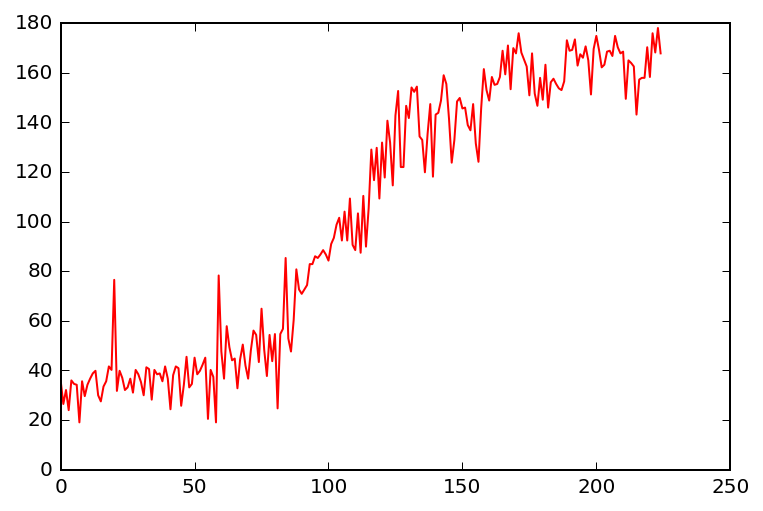

In [4]:
plt.figure()
plt.plot(ph,'-r')

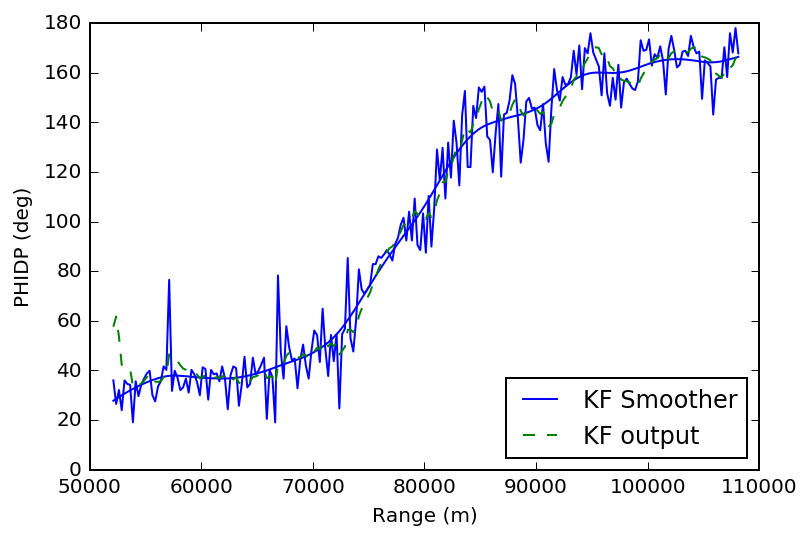

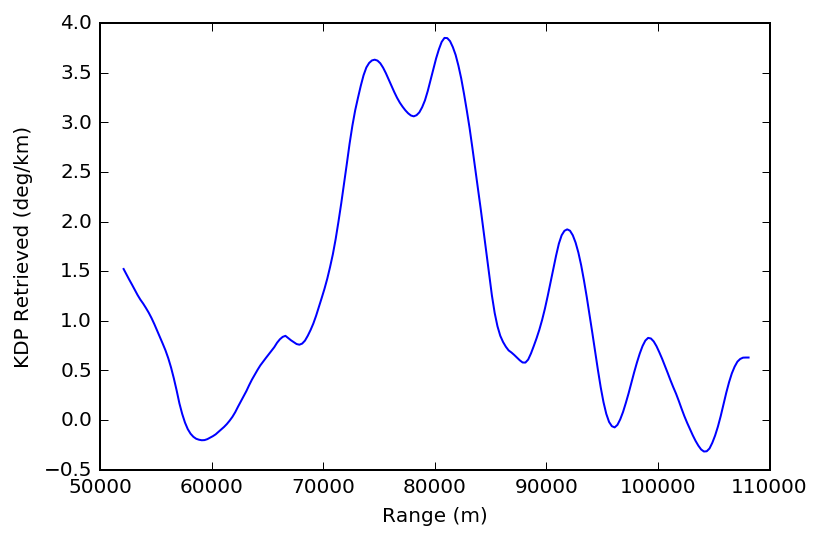

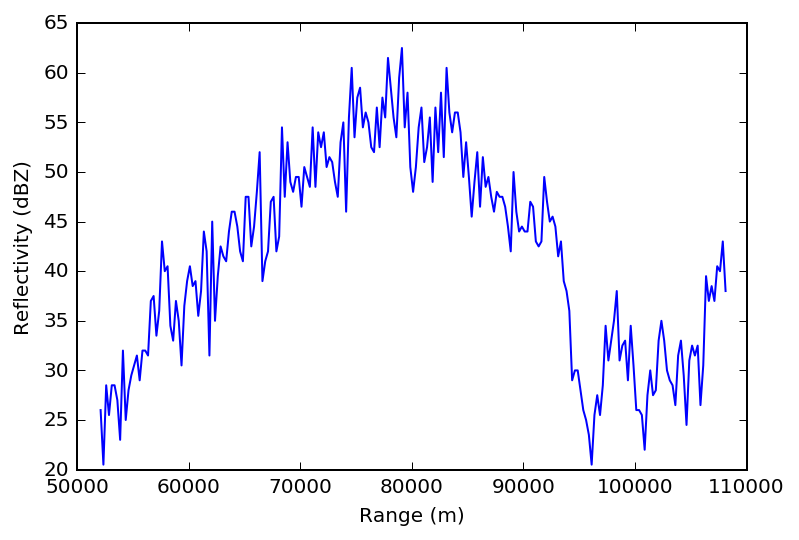

In [17]:
import numpy as np
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

dt=rg[1]-rg[0]
t=rg
Q=0.01
noise=9.

show_velocity=False
fk = KalmanFilter(dim_x=2, dim_z=1)

fk.x = np.array([0., dt])      # state (x and dx)

fk.F = np.array([[1., 1.],
                 [0., 1.]])    # state transition matrix

fk.H = np.array([[1., 0.]])    # Measurement function
fk.P = 10.                     # covariance matrix
fk.R = 2.25                   # state uncertainty
fk.Q = .001                      # process uncertainty

# create noisy data
zs = ph


# filter data with Kalman filter, than run smoother on it
mu, cov, _, _ = fk.batch_filter(zs)
M,P,C = fk.rts_smoother(mu, cov)

# plot data
if show_velocity:
    index = 1
    print('gu')
else:
    index = 0
if not show_velocity:
    plt.plot(rg,zs, lw=1)
plt.plot(rg,M[:, index], c='b', label='KF Smoother')
plt.plot(rg,mu[:, index], c='g', ls='--', label='KF output')
plt.legend(loc=4)
plt.xlabel('Range (m)')
plt.ylabel('PHIDP (deg)')
plt.show()

plt.plot(rg,M[:,1]/(2*dt*.001))
plt.xlabel('Range (m)')
plt.ylabel('KDP Retrieved (deg/km)')
plt.show()

plt.plot(rg,dz)
plt.xlabel('Range (m)')
plt.ylabel('Reflectivity (dBZ)')



In [ ]:
import numpy as np
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

import filterpy.kalman as kf
kf.predict(x=10, P=3., u=1, Q=4)


dt=rg[1]-rg[0]
t=rg
Q=0.01
noise=9.

show_velocity=False
fk = KalmanFilter(dim_x=2, dim_z=1)

fk.x = np.array([0., dt])      # state (x and dx)

fk.F = np.array([[1., 1.],
                 [0., 1.]])    # state transition matrix

fk.H = np.array([[1., 0.]])    # Measurement function
fk.P = 10.                     # covariance matrix
fk.R = 2.25                   # state uncertainty
fk.Q = .001                      # process uncertainty

# create noisy data
zs = ph


# filter data with Kalman filter, than run smoother on it
mu, cov, _, _ = fk.batch_filter(zs)
M,P,C = fk.rts_smoother(mu, cov)

# plot data
if show_velocity:
    index = 1
    print('gu')
else:
    index = 0
if not show_velocity:
    plt.plot(rg,zs, lw=1)
plt.plot(rg,M[:, index], c='b', label='RTS')
plt.plot(rg,mu[:, index], c='g', ls='--', label='KF output')
plt.legend(loc=4)
plt.show()

plt.plot(rg,M[:,1]/(2*dt*.001))

plt.show()

plt.plot(rg,dz)

In [ ]:
from numpy.linalg import inv
from math import sqrt



Q_scale_factor=1000.
std_scale=20.
std_title=False
Q_title=False
cvfilter = make_cv_filter(dt, std=0.2)
initialize_filter(cvfilter)
#pos2, zs2 = generate_data(180-30, std=0.2)
xs2 = rg
z_xs2 = ph

# reinitialize filter
initialize_filter(cvfilter)
cvfilter.R = np.eye(1)*0.2

phi = 0.02
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=phi)
xs, ys = [], []
count = 0
for i,z in zip(t,z_xs2):
    cvfilter.predict()
    cvfilter.update([z])
    y = cvfilter.y
    S = cvfilter.S
    std = sqrt(S)

    xs.append(cvfilter.x)
    ys.append(y)

    if abs(y[0]) > std_scale*std:
        phi += Q_scale_factor
        cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
        count += 1
    elif count > 0:
        phi -= Q_scale_factor
        cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
        count -= 1

xs = np.asarray(xs)


plt.figure()
plt.plot(t, z_xs2, lw=2, label='z')
plt.plot(t, xs,'k.',label='filter')
plt.legend()

In [ ]:
dt

In [ ]:
Q_discrete_white_noise(dim=2, dt=dt, var=.0000000002)

In [ ]:
%config InlineBackend

In [5]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_g

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1, dt],
                     [0,  1]])    # state transition matrix
    kf.H = np.array([[1, 0]])     # Measurement function
    kf.R *= R                   # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q = Q
    return kf

In [6]:
import jupyter_core;jupyter_core.paths.jupyter_config_dir() + '\\custom'

'/Users/snesbitt/.jupyter\\custom'